# Test pipeline
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training loop:
    + Forward 
    + Calculate loss
    + Backward
    + Monitoring: 
        + Evaluate metrics
        + Logger, back and forth
        + Visualize

# Import necessary packages

In [1]:

import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms

import numpy as np

from sklearn.model_selection import ShuffleSplit

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline

sys.path.insert(0, '..')
from src.models.utils import FaceDataset


# Create a transformer

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224),interpolation=Image.NEAREST),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224),interpolation=Image.NEAREST),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def transformer(image, label, params):
    if params["train"]:
        transform = data_transforms["train"]
    else:
        transform = data_transforms["val"]
    image = transform(image) 
    return image, label

# Create Data loader

In [3]:
trans_params_train = {
    "train" : True,
}


trans_params_val={
    "train" : False,
}
path2data = "/home/Data/appa-real/processed/"



In [4]:
# create data set
train_ds = FaceDataset(path2data + "train.csv", transformer, trans_params_train)
val_ds = FaceDataset(path2data + "valid.csv", transformer, trans_params_val)
test_ds = FaceDataset(path2data + "test.csv", transformer, trans_params_val)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

3995
1500
1978


In [5]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


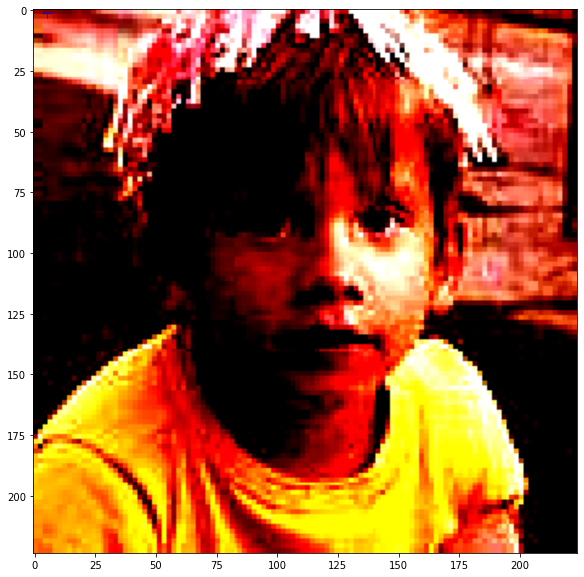

In [6]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


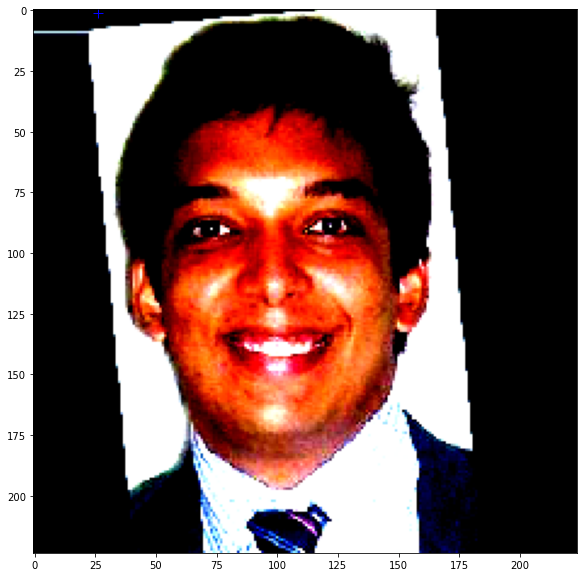

In [7]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [8]:
from torch.utils.data import DataLoader
train_bz = 200
val_bz = 400
train_dl = DataLoader(train_ds, batch_size = train_bz, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = val_bz, shuffle=False)
test_dl = DataLoader(test_ds, batch_size = val_bz, shuffle=False)

In [9]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([200, 3, 224, 224]) torch.float32
torch.Size([200, 2])


In [10]:
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([400, 3, 224, 224]) torch.float32
torch.Size([400, 2])


In [11]:
for img, label in test_dl:
    print(label.shape)
    break

torch.Size([400, 2])



# Create Model

In [12]:
class Net(nn.Module):
    def __init__(self, params_model):
        super(Net, self).__init__()
        
        # Loading Mobilenet v2 arch from PyTorch
        original_model = models.mobilenet_v2(pretrained=True)
        
        # Everything except the last linear layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
        # Get number of features of last layer
        num_feats = 1280
        
        # Plug our heads
        self.gender_head = nn.Sequential(
        nn.Linear(num_feats, 1)
        )
        
        self.age_head = nn.Sequential(
        nn.Linear(num_feats, 1)
        )
        
        if params_model["freeze"]:
        # Freeze all weights except the last classifier layer
            for p in self.features.parameters():
                p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        f = F.adaptive_avg_pool2d(f,1)
        f = f.view(f.size(0), -1)
        gender = F.sigmoid(self.gender_head(f))
        age = self.age_head(f)
        return age, gender

In [13]:
params_model={
        "freeze": False,
            }

model = Net(params_model)
device = torch.device("cuda")
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Net(
    (features): Sequential(
      (0): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv

# Create optimizer

In [14]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10,verbose=1)



# Create custom Performance

In [15]:

from src.models import experiment
from src.models.experiment import Performance

class CustomPerformance(Performance):
    def __init__(self):
        Performance.__init__(self)
        self.gender_loss_func = nn.BCELoss(reduction="sum")
        self.age_loss_func = nn.MSELoss(reduction="sum")
        
    def loss_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        loss_age = self.age_loss_func(age, age_targets)
        
        loss_gender = self.gender_loss_func(gender, gender_targets)
        
        loss = loss_age + 100*loss_gender
        
        return loss

    def metrics_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        gender = gender > 0.5
        acc_gender = (gender == gender_targets).sum()
        
        mae_age = torch.abs(age - age_targets).sum()
        
        return torch.tensor([acc_gender, mae_age])


# Training

In [16]:
performance = CustomPerformance()
num_epochs = 100
path2models= "../models/weights.pt"
params = experiment.Prams(num_epochs=num_epochs, path2weights=path2models, device=device,optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

pipeline = experiment.Pipeline(model, train_dl, val_dl, performance, params)
model, performance = pipeline.train_val()


Epoch 0/99, current lr=0.0001


/home/duc/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Copied best model weights!
train loss: 1106.027466
val loss: 1044.762817
----------
Epoch 1/99, current lr=0.0001
Copied best model weights!
train loss: 914.742554
val loss: 801.020142
----------
Epoch 2/99, current lr=0.0001
Copied best model weights!
train loss: 747.231201
val loss: 793.273438
----------
Epoch 3/99, current lr=0.0001
Copied best model weights!
train loss: 625.570557
val loss: 580.571838
----------
Epoch 4/99, current lr=0.0001
Copied best model weights!
train loss: 545.321777
val loss: 502.834290
----------
Epoch 5/99, current lr=0.0001
Copied best model weights!
train loss: 477.796509
val loss: 485.971924
----------
Epoch 6/99, current lr=0.0001
Copied best model weights!
train loss: 425.044403
val loss: 470.741089
----------
Epoch 7/99, current lr=0.0001
Copied best model weights!
train loss: 376.230164
val loss: 396.427094
----------
Epoch 8/99, current lr=0.0001
Copied best model weights!
train loss: 328.093536
val loss: 368.948029
----------
Epoch 9/99, current 

train loss: 8.077883
val loss: 95.114700
----------
Epoch 86/99, current lr=6.25e-06
train loss: 9.787195
val loss: 96.536079
----------
Epoch 87/99, current lr=6.25e-06
train loss: 8.945292
val loss: 93.847008
----------
Epoch 88/99, current lr=6.25e-06
train loss: 7.256745
val loss: 98.253082
----------
Epoch 89/99, current lr=6.25e-06
train loss: 7.237036
val loss: 95.122742
----------
Epoch 90/99, current lr=6.25e-06
train loss: 8.150450
val loss: 95.283195
----------
Epoch 91/99, current lr=6.25e-06
Epoch    92: reducing learning rate of group 0 to 3.1250e-06.
Loading best model weights!
train loss: 8.349155
val loss: 96.815704
----------
Epoch 92/99, current lr=3.125e-06
train loss: 9.074526
val loss: 94.620148
----------
Epoch 93/99, current lr=3.125e-06
train loss: 9.322001
val loss: 93.365227
----------
Epoch 94/99, current lr=3.125e-06
train loss: 8.543037
val loss: 94.129906
----------
Epoch 95/99, current lr=3.125e-06
train loss: 8.928873
val loss: 94.964981
----------
Epoc

In [17]:
loss_hist, metrics_history = performance.loss_history, performance.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

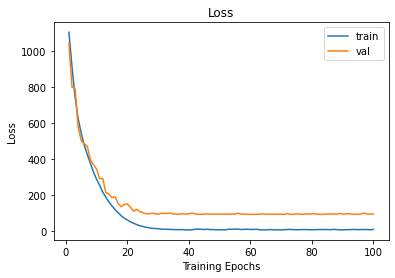

In [18]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

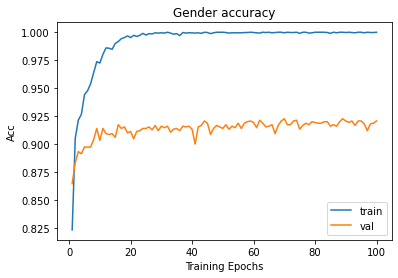

In [19]:
# plot accuracy progress
plt.title("Gender accuracy")
plt.plot(range(1,num_epochs+1),train_hist[:,0], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,0],label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

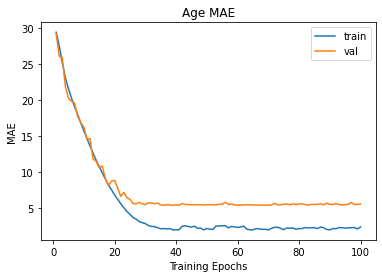

In [20]:
# plot accuracy progress
plt.title("Age MAE")
plt.plot(range(1,num_epochs+1),train_hist[:,1], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,1],label="val")
plt.ylabel("MAE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Testing

In [21]:
loss_test, metrics_test = pipeline.test(test_dl)

/home/duc/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [22]:
# Gender Accuracy
print(max(train_hist[:,0]))
print(max(val_hist[:,0]))
print(metrics_test[0])

tensor(1.)
tensor(0.9227)
tensor(0.8999)


In [23]:
# Age MAE
print(min(train_hist[:,1]))
print(min(val_hist[:,1]))
print(metrics_test[1])

tensor(1.9675)
tensor(5.3688)
tensor(6.3546)


In [24]:
# Loss
print(min(loss_hist["train"]))
print(min(loss_hist["val"]))
print(loss_test)

tensor(6.8821, device='cuda:0', grad_fn=<DivBackward0>)
tensor(93.0572, device='cuda:0')
tensor(109.0011, device='cuda:0')
